In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Standard library
from functools import reduce
from math import ceil
from typing import Dict

# Custom modules and other
import joblib

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Data
import pandas as pd

# XGBoost
import xgboost as xgb

# Hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from imblearn.metrics import classification_report_imbalanced
from sklearn.exceptions import NotFittedError

# Machine learning
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
    log_loss,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

print("XGB Version", xgb.__version__)

XGB Version 1.7.2


## Global Settings

In [3]:
seed = 27
rs = np.random.RandomState(seed)

# Folds
folds = 5

# Paths
data_path = "../data/train_test/"
model_path = "../outputs/models/"
pipe_path = "../outputs/pipeline/"
plot_path = "../outputs/plots/"

top_num_features = 25

## Data

In [7]:
train_X, train_y = (
    pd.read_parquet(data_path + "train_X.parquet"),
    pd.read_parquet(data_path + "train_y.parquet")
    .to_numpy()
    .reshape(
        -1,
    ),
)

In [8]:
train_X.shape, train_y.shape

((81412, 49), (81412,))

## Hyperparameter Search Using Bayesian Optimization

The models with default parameters suffer from severe overfitting. We need to optimize the hyperparameter to reduce the variance. We will use Bayesian optimization to search through the hyperparameter search space. The `hyperopt` package's implementation of the Tree-structured Parzen Estimator algorithm is what we will use.

* First, define the search space:

In [14]:
# Search space
search_space = {
    # Booster parameters
    "booster_params": {
        "booster": "gbtree",
        "objective": "multi:softprob",
        "num_class": 3,
        "learning_rate": hp.uniform(
            "learning_rate", 0.001, 0.3
        ),  # Range: [0, 1], larger eta shrinks the feature weights more to make the boosting process more conservative, i.e., fewer trees (regularizer)
        "gamma": hp.randint(
            "gamma", 0, 9
        ),  # Range: [0, inf], the larger the more conservative the algorithm (regularizer)
        "max_delta_step": hp.randint(
            "max_delta_step", 1, 10
        ),  # Range: [0, inf], values from 1-10 might help control the update for imbalanced data (regularizer)
        "lambda": hp.choice(
            "lambda", [1, 10, 100]
        ),  # Range: [0, inf], L2 regularization term on weights, the larger the more conservative the algorithm (regularizer)
        "alpha": hp.choice(
            "alpha", [1, 10, 100]
        ),  # Range: [0, inf], L1 regularization term on weights, the larger the more conservative the algorithm (regularizer)
        "colsample_bylevel": hp.choice(
            "colsample_bylevel", np.linspace(0.5, 1, 6).tolist()
        ),
        "colsample_bynode": hp.choice(
            "colsample_bynode", np.linspace(0.5, 1, 6).tolist()
        ),
        "colsample_bytree": hp.choice(
            "colsample_bytree", np.linspace(0.5, 1, 6).tolist()
        ),  # Range: (0, 1], subsample ratio of columns when constructing each tree, the smaller the more conservative the algorithm (regularizer)
        "subsample": hp.choice(
            "subsample", np.linspace(0.5, 1, 6).tolist()
        ),  # Range: (0, 1], subsample ratio of the training instances every boosting iteration, the smaller the more conservative the algorithm (regularizer)
        "max_depth": hp.choice(
            "max_depth", np.arange(3, 12, dtype=np.int16).tolist()
        ),  # Range: [0, inf], deep trees boost predictive power but are more likely to overfit (bias reducer)
        "tree_method": "hist",
        "predictor": "cpu_predictor",
        "eval_metric": "mlogloss",
    },
    # Non-booster parameters
    "num_feat": hp.choice("num_feat", [50, 60, 70, 80]),
    "step": hp.choice("step", [0.1, 0.2, 0.3]),
    "k_neighbors": hp.choice("k_neighbors", [5, 10, 15, 20, 25, 30]),
    "num_boost_round": hp.randint(
        "num_boost_round", 500, 2000
    ),  # Range: [0, inf], number of boosting iterations, the larger the more likely to overfit (bias reducer)
}

* Next, we define the objective function, which contains our cross-validation logic and returns the loss value we wish to minimize:

In [16]:
def objective(params: Dict):
    # Create copies since we passed mutable objects
    train_X, train_y = (
        pd.read_parquet("../data/train_test/train_X.parquet"),
        pd.read_parquet("../data/train_test/train_y.parquet")
        .to_numpy()
        .reshape(
            -1,
        ),
    )
    folds = 3
    seed = 1227

    print(params)

    # Stratified K-fold cross-validation
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    losses = np.empty(folds)
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
        # Train and validation sets
        fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
        fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]

        # Processing using fresh copies for every fold
        print(f"Start processing fold {fold + 1}...")
        preprocessor = joblib.load(pipe_path + "preprocessor.joblib")
        label_encoder = joblib.load(pipe_path + "label_encoder.joblib")
        # Fit and transform on training data
        fold_train_X = preprocessor.fit_transform(fold_train_X)
        fold_train_y = label_encoder.fit_transform(fold_train_y)
        # Transform validation data
        fold_val_X = preprocessor.transform(fold_val_X)
        fold_val_y = label_encoder.transform(fold_val_y)

        # Feature selection (tuning number of features and step size)
        selector = RFE(
            estimator=DecisionTreeClassifier(random_state=seed),
            n_features_to_select=int(params["num_feat"]),
            step=float(params["step"]),
        )
        fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
        fold_val_X = selector.transform(fold_val_X)

        # Computing sample instance weights
        print("Class distribution:", np.unique(fold_train_y, return_counts=True))
        instance_weights = compute_sample_weight("balanced", fold_train_y)
        print(
            "Class instance weights:", np.unique(instance_weights, return_counts=True)
        )

        # Model (tuning hyperparameters)
        print(f"Start training model for fold {fold + 1}...")
        feature_names = selector.get_feature_names_out().tolist()
        # Apply weights to training and not validation data
        dtrain = xgb.DMatrix(
            data=fold_train_X,
            label=fold_train_y,
            feature_names=feature_names,
            weight=instance_weights,
        )
        dvalid = xgb.DMatrix(
            data=fold_val_X, label=fold_val_y, feature_names=feature_names
        )
        model = xgb.train(
            params=params["booster_params"],
            dtrain=dtrain,
            num_boost_round=int(params["num_boost_round"]),
            early_stopping_rounds=400,
            evals=[(dtrain, "train"), (dvalid, "validate")],
            verbose_eval=200,
        )

        # Out-of-fold prediction for the current fold
        print(f"Predicting for fold {fold + 1}...")
        oof_pred = model.predict(data=dvalid)
        losses[fold] = log_loss(y_true=fold_val_y, y_pred=oof_pred)

    mean_log_loss = np.mean(losses)

    print(f"Average log loss: {mean_log_loss}")

    return {"loss": mean_log_loss, "status": STATUS_OK}

* Minimize the objective function with the optimal value (multi-class log-loss) with respect to the hyperparameters:

In [17]:
trials = Trials()

best_params = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=100, trials=trials
)

{'booster_params': {'alpha': 10, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 0.6, 'colsample_bytree': 0.9, 'eval_metric': 'mlogloss', 'gamma': 8, 'lambda': 100, 'learning_rate': 0.13624554527758775, 'max_delta_step': 2, 'max_depth': 7, 'num_class': 3, 'objective': 'multi:softprob', 'predictor': 'cpu_predictor', 'subsample': 1.0, 'tree_method': 'hist'}, 'k_neighbors': 15, 'num_boost_round': 1844, 'num_feat': 50, 'step': 0.1}
Start processing fold 1...                             
Class distribution:                                    
(array([0, 1, 2]), array([ 6056, 18957, 29261]))       
Class instance weights:                                
(array([0.61827461, 0.95433525, 2.98734038]), array([29261, 18957,  6056]))
Start training model for fold 1...                     
[0]	train-mlogloss:1.07293	validate-mlogloss:1.06972   
[200]	train-mlogloss:0.90347	validate-mlogloss:0.89122 
[400]	train-mlogloss:0.90347	validate-mlogloss:0.89122 
[461]	train-mlogloss:0.90

Based on the search, the best set of parameters are as follows:

In [19]:
best_params

{'alpha': 0,
 'colsample_bylevel': 4,
 'colsample_bynode': 3,
 'colsample_bytree': 4,
 'gamma': 1,
 'k_neighbors': 4,
 'lambda': 0,
 'learning_rate': 0.029621786689346695,
 'max_delta_step': 5,
 'max_depth': 6,
 'num_boost_round': 1043,
 'num_feat': 1,
 'step': 0,
 'subsample': 3}

Note that for `hp.choice`, the returned values is not the actual values of the hyperparamter but simply the indices to the choice lists. 

* The `colsample_bynode` returns $3$, which corresponds to the fourth element of the choice list--- `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`--- 1.0. 

* The `colsample_bytree` returns $4$, which correponds to  the fifth element of the choice list--- `[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`--- 0.8.

We can simply use the dictionary from the standard output and modify as necessary.

In [9]:
optimal_params = {
    "booster_params": {
        "alpha": 1,
        "booster": "gbtree",
        "colsample_bylevel": 0.9,
        "colsample_bynode": 0.8,
        "colsample_bytree": 0.9,
        "eval_metric": "mlogloss",
        "gamma": 1,
        "lambda": 1,
        "learning_rate": 0.021239520998594802,
        "max_delta_step": 5,
        "max_depth": 9,
        "num_class": 3,
        "objective": "multi:softprob",
        "predictor": "cpu_predictor",
        "subsample": 0.8,
        "tree_method": "hist",
    },
    "k_neighbors": 25,
    "num_boost_round": 10000,
    "num_feat": 60,
    "step": 0.1,
}
optimal_params

{'booster_params': {'alpha': 1,
  'booster': 'gbtree',
  'colsample_bylevel': 0.9,
  'colsample_bynode': 0.8,
  'colsample_bytree': 0.9,
  'eval_metric': 'mlogloss',
  'gamma': 1,
  'lambda': 1,
  'learning_rate': 0.021239520998594802,
  'max_delta_step': 5,
  'max_depth': 9,
  'num_class': 3,
  'objective': 'multi:softprob',
  'predictor': 'cpu_predictor',
  'subsample': 0.8,
  'tree_method': 'hist'},
 'k_neighbors': 25,
 'num_boost_round': 10000,
 'num_feat': 60,
 'step': 0.1}

We can now use this optimized set of parameters as a starting point for cross validation.

## Training with K-fold CV

In [11]:
# Out-of-fold prediction dictionary
oof = {}
# Feature importance container
feat_imp_list = []
# Classification report container
clf_report_list = []
# CV splitter
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_X, train_y)):
    # Print messages to console
    print("#" * 80)
    print("# Fold", fold + 1)
    print("# Training set size", len(train_idx), "Validation set size", len(val_idx))
    print("#" * 80)

    # Check that the indices are indeed disjoint for training and validation set
    print(
        "The training and validation sets are disjoint:",
        set(train_idx).isdisjoint(set(val_idx)),
    )

    # Train and validation sets
    fold_train_X, fold_train_y = train_X.iloc[train_idx], train_y[train_idx]
    fold_val_X, fold_val_y = train_X.iloc[val_idx], train_y[val_idx]

    # Preprocessing
    preprocessor = joblib.load("../outputs/pipeline/preprocessor.joblib")
    label_encoder = joblib.load("../outputs/pipeline/label_encoder.joblib")
    try:
        preprocessor.transform(train_X)
    except NotFittedError:
        print("The preprocessor is not fitted yet. Fitting now...")
    try:
        label_encoder.transform(train_y)
    except NotFittedError:
        print("The label encoder is not fitted yet. Fitting now...")
    # Fit and transform on training data
    fold_train_X = preprocessor.fit_transform(train_X)
    fold_train_y = label_encoder.fit_transform(train_y)
    # Transform validation data
    fold_val_X = preprocessor.transform(fold_val_X)
    fold_val_y = label_encoder.transform(fold_val_y)
    # Store fitted preprocessor and label encoder
    joblib.dump(
        preprocessor, f"../outputs/pipeline/preprocessor_fold_{fold + 1}.joblib"
    )
    joblib.dump(
        label_encoder, f"../outputs/pipeline/label_encoder_fold_{fold + 1}.joblib"
    )

    # Feature selection
    selector = RFE(
        estimator=DecisionTreeClassifier(random_state=rs),
        n_features_to_select=optimal_params["num_feat"],
        step=optimal_params["step"],
    )
    try:
        selector.transform(fold_train_X)
    except NotFittedError:
        print("The feature selector is not fitted yet. Fitting now...")
    fold_train_X = selector.fit_transform(fold_train_X, fold_train_y)
    fold_val_X = selector.transform(fold_val_X)
    # Store fitted feature selector
    joblib.dump(
        selector, f"../outputs/pipeline/feature_selector_fold_{fold + 1}.joblib"
    )

    # Obtaining training data class weight after resampling
    print(
        "Class distribution:",
        np.unique(fold_train_y, return_counts=True)[1] / len(fold_train_y),
    )
    instance_weights = compute_sample_weight("balanced", fold_train_y)
    print("Class instance weights:", np.unique(instance_weights, return_counts=True))

    # Container for evaluation results
    evals_result = {}
    # Model, applying weights to the training data and not the validation data
    dtrain = xgb.DMatrix(
        data=fold_train_X,
        label=fold_train_y,
        feature_names=selector.get_feature_names_out().tolist(),
        weight=instance_weights,
    )
    dvalid = xgb.DMatrix(
        data=fold_val_X,
        label=fold_val_y,
        feature_names=selector.get_feature_names_out().tolist(),
    )
    model = xgb.train(
        params=optimal_params["booster_params"],
        dtrain=dtrain,
        num_boost_round=optimal_params["num_boost_round"],
        early_stopping_rounds=400,
        evals=[(dtrain, "train"), (dvalid, "validate")],
        evals_result=evals_result,
        verbose_eval=1000,
    )
    model.save_model(model_path + f"model_fold_{fold + 1}.xgb")
    joblib.dump(evals_result, model_path + f"eval_fold_{fold + 1}.joblib")

    # Feature importance for the current fold
    # The booster object has a get_score method that returns a dictionary of feature names and their importance scores
    feat_imp = model.get_score(importance_type="weight")
    df = pd.DataFrame(
        {"feature": feat_imp.keys(), f"importance_{fold + 1}": feat_imp.values()}
    )
    # Add the current fold's feature importance to the container
    feat_imp_list.append(df)

    # Out-of-fold prediction, matrix of probabilities with shape (n_samples, n_classes)
    oof_pred = model.predict(dvalid)
    pred_classes = np.argmax(oof_pred, axis=1)
    # Add the current fold's out-of-fold prediction to the dictionary with target values
    oof[f"fold_{fold + 1}"] = {"target": fold_val_y, "prediction": oof_pred}
    # Add report to container
    clf_report_list.append(
        classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes)
    )
    # Print multi-class logloss and balanced accuracy (average recall (i.e., the ability of the classifier to find all the positive samples) for each class)
    print(
        "Multi-class logloss:",
        log_loss(y_true=fold_val_y, y_pred=oof_pred, labels=[0, 1, 2]),
    )
    print(
        "Balanced accuracy (Average recall):",
        balanced_accuracy_score(y_true=fold_val_y, y_pred=pred_classes),
    )
    print(classification_report_imbalanced(y_true=fold_val_y, y_pred=pred_classes))

    del (
        fold_train_X,
        fold_train_y,
        fold_val_X,
        fold_val_y,
        dtrain,
        dvalid,
        model,
        feat_imp,
        oof_pred,
        pred_classes,
    )

################################################################################
# Fold 1
# Training set size 65129 Validation set size 16283
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_1.joblib']

['../outputs/pipeline/label_encoder_fold_1.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_1.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-mlogloss:1.09060	validate-mlogloss:1.09210
[1000]	train-mlogloss:0.49258	validate-mlogloss:0.75476
[2000]	train-mlogloss:0.43132	validate-mlogloss:0.73051
[3000]	train-mlogloss:0.41110	validate-mlogloss:0.72302
[4000]	train-mlogloss:0.40035	validate-mlogloss:0.71932
[5000]	train-mlogloss:0.39369	validate-mlogloss:0.71711
[6000]	train-mlogloss:0.38842	validate-mlogloss:0.71540
[7000]	train-mlogloss:0.38503	validate-mlogloss:0.71419
[8000]	train-mlogloss:0.38165	validate-mlogloss:0.71293
[9000]	train-mlogloss:0.37858	validate-mlogloss:0.71155
[9999]	train-mlogloss:0.37589	validate-mlogloss:0.71055


['../outputs/models/eval_fold_1.joblib']

Multi-class logloss: 0.7105462577036723
Balanced accuracy (Average recall): 0.5702642929962398
                   pre       rec       spe        f1       geo       iba       sup

          0       0.69      0.41      0.98      0.52      0.64      0.38      1817
          1       0.78      0.35      0.95      0.48      0.57      0.31      5688
          2       0.66      0.95      0.43      0.78      0.64      0.43      8778

avg / total       0.70      0.68      0.67      0.64      0.61      0.38     16283

################################################################################
# Fold 2
# Training set size 65129 Validation set size 16283
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_2.joblib']

['../outputs/pipeline/label_encoder_fold_2.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_2.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-mlogloss:1.09060	validate-mlogloss:1.09211
[1000]	train-mlogloss:0.49258	validate-mlogloss:0.75747
[2000]	train-mlogloss:0.43132	validate-mlogloss:0.73276
[3000]	train-mlogloss:0.41110	validate-mlogloss:0.72444
[4000]	train-mlogloss:0.40035	validate-mlogloss:0.72014
[5000]	train-mlogloss:0.39369	validate-mlogloss:0.71772
[6000]	train-mlogloss:0.38842	validate-mlogloss:0.71600
[7000]	train-mlogloss:0.38503	validate-mlogloss:0.71493
[8000]	train-mlogloss:0.38165	validate-mlogloss:0.71361
[9000]	train-mlogloss:0.37858	validate-mlogloss:0.71225
[9999]	train-mlogloss:0.37589	validate-mlogloss:0.71123


['../outputs/models/eval_fold_2.joblib']

Multi-class logloss: 0.7112275309821218
Balanced accuracy (Average recall): 0.5718789061490636
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.42      0.98      0.53      0.64      0.39      1817
          1       0.77      0.34      0.95      0.47      0.57      0.30      5687
          2       0.66      0.95      0.42      0.78      0.64      0.43      8779

avg / total       0.70      0.68      0.67      0.64      0.61      0.38     16283

################################################################################
# Fold 3
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_3.joblib']

['../outputs/pipeline/label_encoder_fold_3.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_3.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-mlogloss:1.09060	validate-mlogloss:1.09226
[1000]	train-mlogloss:0.49258	validate-mlogloss:0.75823
[2000]	train-mlogloss:0.43132	validate-mlogloss:0.73462
[3000]	train-mlogloss:0.41110	validate-mlogloss:0.72702
[4000]	train-mlogloss:0.40035	validate-mlogloss:0.72303
[5000]	train-mlogloss:0.39369	validate-mlogloss:0.72089
[6000]	train-mlogloss:0.38842	validate-mlogloss:0.71919
[7000]	train-mlogloss:0.38503	validate-mlogloss:0.71804
[8000]	train-mlogloss:0.38165	validate-mlogloss:0.71692
[9000]	train-mlogloss:0.37858	validate-mlogloss:0.71567
[9999]	train-mlogloss:0.37589	validate-mlogloss:0.71472


['../outputs/models/eval_fold_3.joblib']

Multi-class logloss: 0.7147174204066138
Balanced accuracy (Average recall): 0.5688914316025578
                   pre       rec       spe        f1       geo       iba       sup

          0       0.70      0.42      0.98      0.52      0.64      0.39      1817
          1       0.79      0.33      0.95      0.47      0.56      0.30      5687
          2       0.66      0.96      0.41      0.78      0.63      0.42      8778

avg / total       0.71      0.68      0.66      0.64      0.61      0.37     16282

################################################################################
# Fold 4
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_4.joblib']

['../outputs/pipeline/label_encoder_fold_4.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_4.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-mlogloss:1.09060	validate-mlogloss:1.09226
[1000]	train-mlogloss:0.49258	validate-mlogloss:0.74686
[2000]	train-mlogloss:0.43132	validate-mlogloss:0.72069
[3000]	train-mlogloss:0.41110	validate-mlogloss:0.71184
[4000]	train-mlogloss:0.40035	validate-mlogloss:0.70734
[5000]	train-mlogloss:0.39369	validate-mlogloss:0.70489
[6000]	train-mlogloss:0.38842	validate-mlogloss:0.70292
[7000]	train-mlogloss:0.38503	validate-mlogloss:0.70160
[8000]	train-mlogloss:0.38165	validate-mlogloss:0.70017
[9000]	train-mlogloss:0.37858	validate-mlogloss:0.69880
[9999]	train-mlogloss:0.37589	validate-mlogloss:0.69776


['../outputs/models/eval_fold_4.joblib']

Multi-class logloss: 0.6977592059906331
Balanced accuracy (Average recall): 0.5911424555446585
                   pre       rec       spe        f1       geo       iba       sup

          0       0.72      0.46      0.98      0.56      0.67      0.43      1817
          1       0.79      0.36      0.95      0.50      0.59      0.32      5687
          2       0.67      0.95      0.44      0.78      0.65      0.44      8778

avg / total       0.72      0.69      0.68      0.66      0.63      0.40     16282

################################################################################
# Fold 5
# Training set size 65130 Validation set size 16282
################################################################################
The training and validation sets are disjoint: True
The preprocessor is not fitted yet. Fitting now...
The label encoder is not fitted yet. Fitting now...


['../outputs/pipeline/preprocessor_fold_5.joblib']

['../outputs/pipeline/label_encoder_fold_5.joblib']

/Users/kenwu/opt/anaconda3/envs/python_for_machine_learning/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RFE was fitted without feature names
  warnings.warn(


The feature selector is not fitted yet. Fitting now...


['../outputs/pipeline/feature_selector_fold_5.joblib']

Class distribution: [0.11159289 0.34928512 0.539122  ]
Class instance weights: (array([0.61828925, 0.95433019, 2.98704825]), array([43891, 28436,  9085]))
[0]	train-mlogloss:1.09060	validate-mlogloss:1.09248
[1000]	train-mlogloss:0.49258	validate-mlogloss:0.75846
[2000]	train-mlogloss:0.43132	validate-mlogloss:0.73214
[3000]	train-mlogloss:0.41110	validate-mlogloss:0.72355
[4000]	train-mlogloss:0.40035	validate-mlogloss:0.71893
[5000]	train-mlogloss:0.39369	validate-mlogloss:0.71626
[6000]	train-mlogloss:0.38842	validate-mlogloss:0.71433
[7000]	train-mlogloss:0.38503	validate-mlogloss:0.71294
[8000]	train-mlogloss:0.38165	validate-mlogloss:0.71159
[9000]	train-mlogloss:0.37858	validate-mlogloss:0.71011
[9999]	train-mlogloss:0.37589	validate-mlogloss:0.70896


['../outputs/models/eval_fold_5.joblib']

Multi-class logloss: 0.7089625423678502
Balanced accuracy (Average recall): 0.582086402146765
                   pre       rec       spe        f1       geo       iba       sup

          0       0.66      0.45      0.97      0.53      0.66      0.41      1817
          1       0.78      0.35      0.95      0.48      0.57      0.31      5687
          2       0.67      0.95      0.44      0.78      0.65      0.44      8778

avg / total       0.71      0.68      0.68      0.65      0.62      0.39     16282



## Performance on Validation Set

One quick way to benchmark the model performance is using the multi-class log-loss:

In [12]:
avg_log_loss = 0
for fold in range(5):
    avg_log_loss += log_loss(
        y_true=oof[f"fold_{fold + 1}"]["target"],
        y_pred=oof[f"fold_{fold + 1}"]["prediction"],
        labels=[0, 1, 2],
    )
avg_log_loss /= 5
print("Average multi-class logloss:", avg_log_loss)

Average multi-class logloss: 0.7086425914901782


A random guess model, when the dataset is imbalanced, simply uses the overall proportions of the traning examples belonging to each class as the predicted probabilities for each class. We can implement a function below that computes the multi-class log loss values given any array of class proportions and sample size.

In [224]:
def rand_guess_log_loss(class_ratio, sample_size):
    if sum(class_ratio) != 1.0:
        class_ratio[-1] += 1 - sum(
            class_ratio
        )  # Add the difference to the last class ratio

    true_y = []
    for ith_class_label, ith_class_ratio in enumerate(class_ratio):
        true_y = true_y + [
            ith_class_label for val in range(ceil(ith_class_ratio * sample_size))
        ]

    # The 'random guess' predictions simply predict the class ratios
    preds = []
    for i in range(len(true_y)):
        preds += [class_ratio]

    return log_loss(true_y, preds)

In [225]:
# Compute the average class ratios across five folds
avg_class_ratios = 0
for fold in range(5):
    avg_class_ratios += np.unique(
        oof[f"fold_{fold + 1}"]["target"], return_counts=True
    )[1] / len(oof[f"fold_{fold + 1}"]["target"])
avg_class_ratios /= 5
avg_class_ratios

array([0.11159289, 0.34928512, 0.539122  ])

In [226]:
# Sample sizes across five folds
sample_size = (
    reduce(
        lambda x, y: x + y,
        [len(oof[f"fold_{fold + 1}"]["target"]) for fold in range(5)],
    )
    // 5
)
sample_size

16282

In [227]:
rand_guess_log_loss(avg_class_ratios, sample_size)

0.9451992625850723

As can be seen, our log loss values are all lower than this benchmark.

In [228]:
print("Average multi-class logloss:", avg_log_loss)

Average multi-class logloss: 0.7087826433332591


### Learning Curve

Text(0.5, 1.0, 'Fold 1 Learning Curve')

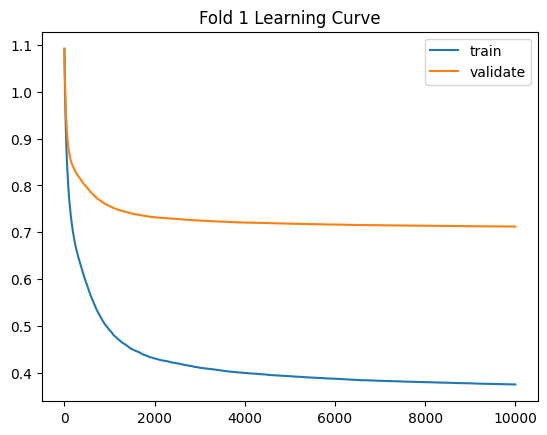

Text(0.5, 1.0, 'Fold 2 Learning Curve')

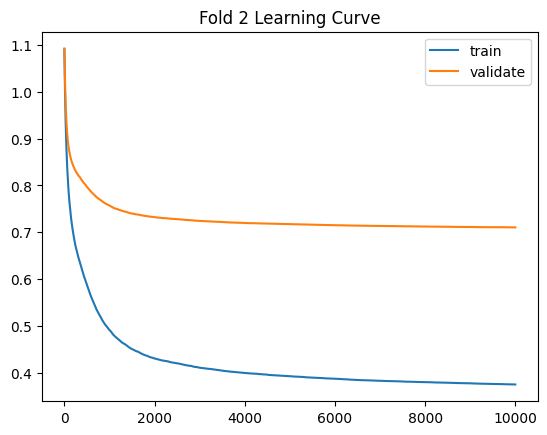

Text(0.5, 1.0, 'Fold 3 Learning Curve')

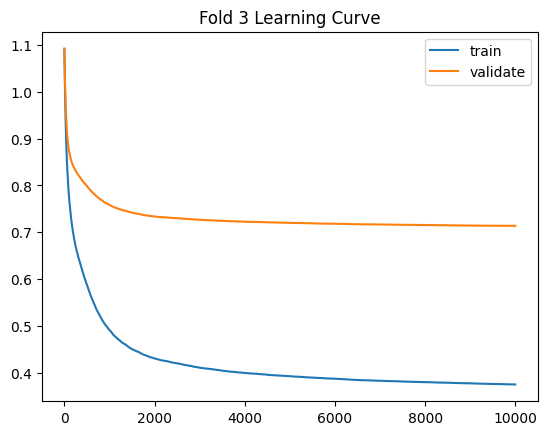

Text(0.5, 1.0, 'Fold 4 Learning Curve')

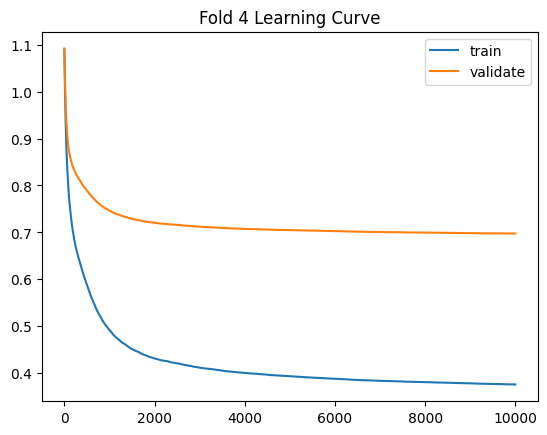

Text(0.5, 1.0, 'Fold 5 Learning Curve')

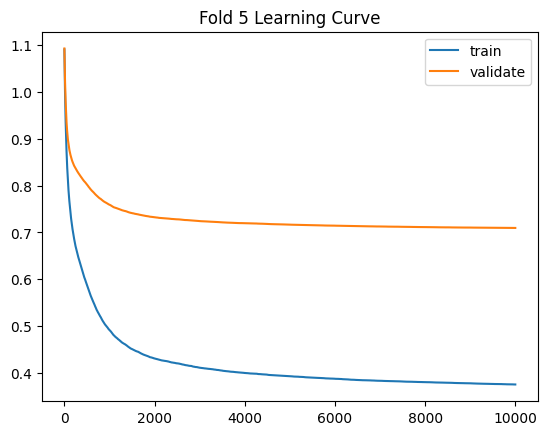

In [237]:
for fold in range(5):
    eval_result = joblib.load(model_path + f"eval_fold_{fold + 1}.joblib")
    plt.plot(eval_result["train"]["mlogloss"], label="train")
    plt.plot(eval_result["validate"]["mlogloss"], label="validate")
    plt.legend()
    plt.title(f"Fold {fold + 1} Learning Curve")
    plt.show()

As can be seen, at around 2000 rounds, the learning rate begins to plateau. Although the log-loss value continuous to decrease, the rate at which it decreases is increasing lower.

### Confusion Matrix

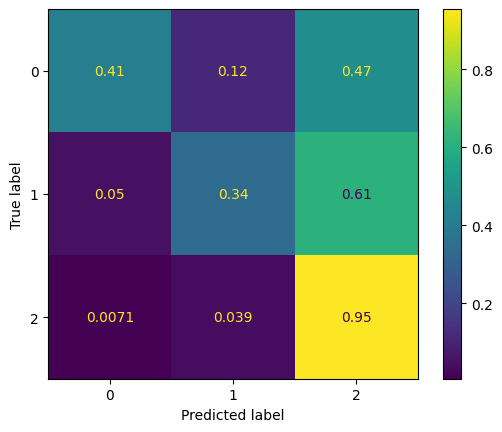

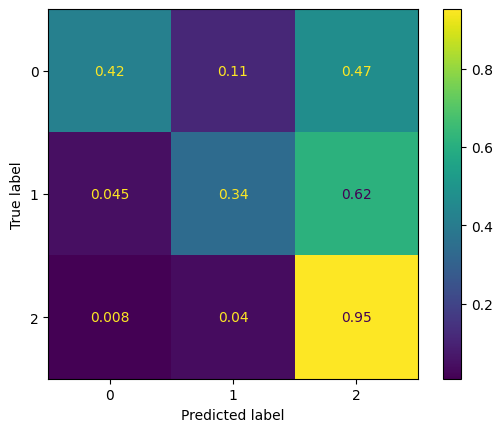

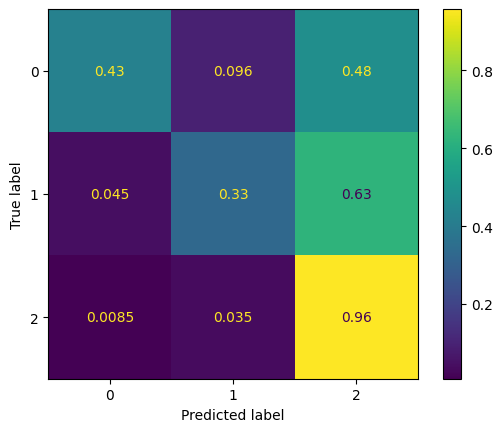

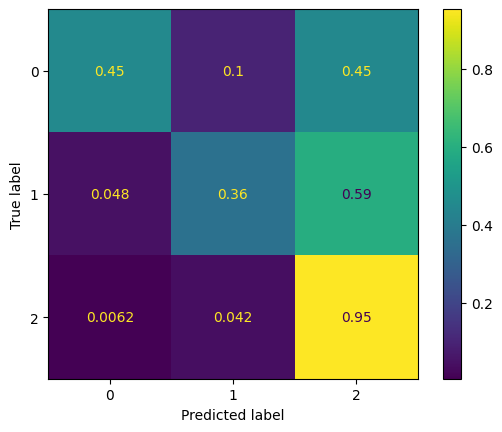

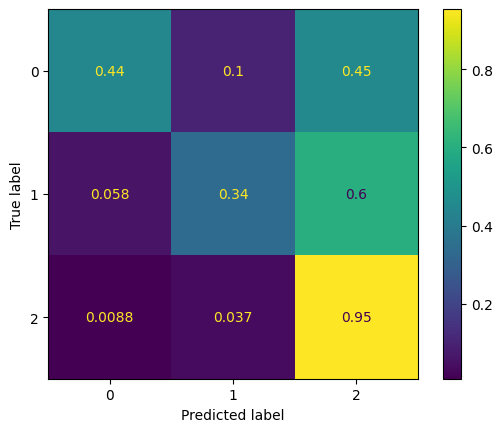

In [238]:
for fold in range(5):
    # Compute predictions for the current fold, summing up the counts across the rows of the matrices for each true label
    ConfusionMatrixDisplay(
        confusion_matrix(
            y_true=oof[f"fold_{fold + 1}"]["target"],
            y_pred=np.argmax(oof[f"fold_{fold + 1}"]["prediction"], axis=1),
            labels=[0, 1, 2],
            normalize="true",
        )
    ).plot()
    plt.show()

Due to the nature of the problem, we would likely wish to focus on the top row. Specifically, we would want to maximize the top left corner, which corresponds to cases where the model correctly classified patient as a member of the '<30' group, i.e., the patient was readmitted into the hospital within 30 days. This is because the cost of miss-classifying a patient who is a high-risk in terms of within 30-day readmission is very high. 

* Even though our model out performs the random guessing model. It still remains suboptimal in terms of our objective--- maximizing the classifier's ability to correctly identify patients who are high-risk of readmission. 

* For the first fold, the classifier correctly classified class 0 ('<30') patients $43\%$ of the time; however, its false negative rate is $57\%$, which is still too costly. This performance in terms correctly classifying the with-30 group is consistent across all folds.

* The most significant improvements of the model's performance on correctly classifiying the within-30 group comes from using sample weights (not resampling techniques such as SMOTE).

* In maximizing the model's ability to correctly classify the within-30 group (class 0), we have lost some accuracy in predicting the above 30 group. Therefore, there is some trade-off between the two minority groups.

## Feature Importance

In [239]:
# Order the feature importance for each fold
for i in range(5):
    feat_imp_list[i].sort_values(by=f"importance_{i + 1}", ascending=True, inplace=True)

In [240]:
feat_imp = reduce(
    lambda x, y: pd.merge(
        x.iloc[-top_num_features:], y.iloc[-top_num_features:], on="feature", how="left"
    ),
    feat_imp_list,
)
feat_imp

,feature,importance_1,importance_2,importance_3,importance_4,importance_5
0,insulin,10659.0,10659.0,10659.0,10659.0,10659.0
1,number_inpatient,11069.0,11069.0,11069.0,11069.0,11069.0
2,number_outpatient_mean_by_patient_nbr,12745.0,12745.0,12745.0,12745.0,12745.0
3,number_inpatient_mean_by_patient_nbr,13279.0,13279.0,13279.0,13279.0,13279.0
4,number_diagnoses_mean_by_patient_nbr,13486.0,13486.0,13486.0,13486.0,13486.0
5,number_diagnoses_sum_by_patient_nbr,13947.0,13947.0,13947.0,13947.0,13947.0
6,time_in_hospital_sum_by_patient_nbr,14133.0,14133.0,14133.0,14133.0,14133.0
7,num_procedures_mean_by_patient_nbr,14440.0,14440.0,14440.0,14440.0,14440.0
8,num_medications_median_by_patient_nbr,15062.0,15062.0,15062.0,15062.0,15062.0
9,payer_code,15410.0,15410.0,15410.0,15410.0,15410.0


Compute the average importance across all five folds:

In [241]:
feat_imp["avg_importance"] = feat_imp.iloc[:, 1:].apply(lambda x: x.mean(), axis=1)
feat_imp

,feature,importance_1,importance_2,importance_3,importance_4,importance_5,avg_importance
0,insulin,10659.0,10659.0,10659.0,10659.0,10659.0,10659.0
1,number_inpatient,11069.0,11069.0,11069.0,11069.0,11069.0,11069.0
2,number_outpatient_mean_by_patient_nbr,12745.0,12745.0,12745.0,12745.0,12745.0,12745.0
3,number_inpatient_mean_by_patient_nbr,13279.0,13279.0,13279.0,13279.0,13279.0,13279.0
4,number_diagnoses_mean_by_patient_nbr,13486.0,13486.0,13486.0,13486.0,13486.0,13486.0
5,number_diagnoses_sum_by_patient_nbr,13947.0,13947.0,13947.0,13947.0,13947.0,13947.0
6,time_in_hospital_sum_by_patient_nbr,14133.0,14133.0,14133.0,14133.0,14133.0,14133.0
7,num_procedures_mean_by_patient_nbr,14440.0,14440.0,14440.0,14440.0,14440.0,14440.0
8,num_medications_median_by_patient_nbr,15062.0,15062.0,15062.0,15062.0,15062.0,15062.0
9,payer_code,15410.0,15410.0,15410.0,15410.0,15410.0,15410.0


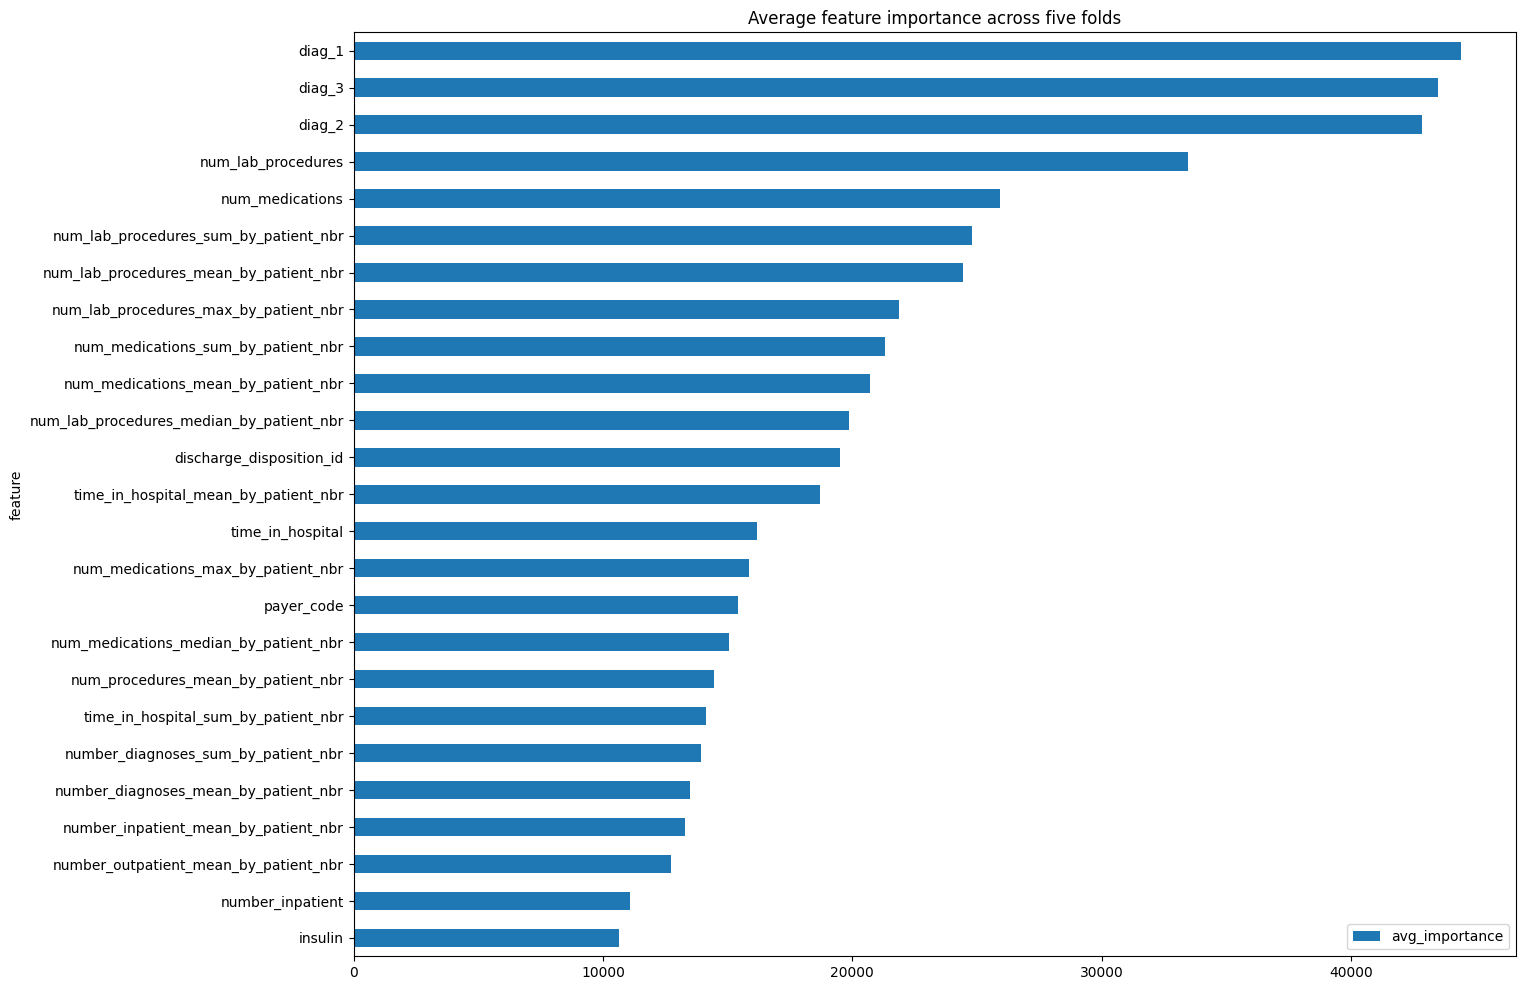

In [243]:
feat_imp_plot = feat_imp.sort_values(by="avg_importance").plot(
    kind="barh",
    x="feature",
    y="avg_importance",
    figsize=(15, 12),
    title="Average feature importance across five folds",
)
feat_imp_plot.figure.savefig(
    "../outputs/plots/feature_importance.pdf", bbox_inches="tight"
)

## Predictions on Test Data

Take the average of each model's predictions (cross-validation averaging):

In [13]:
test_X, test_y = (
    pd.read_parquet(data_path + "test_X.parquet"),
    pd.read_parquet(data_path + "test_y.parquet")
    .to_numpy()
    .reshape(
        -1,
    ),
)
test_X.shape, test_y.shape

((20354, 49), (20354,))

In [14]:
test_y = joblib.load("../outputs/pipeline/label_encoder.joblib").fit_transform(test_y)
test_y

array([2, 2, 2, ..., 1, 1, 1])

In [15]:
pred = np.zeros(shape=(test_X.shape[0], 3))
for i in range(5):
    # Initialize the model
    model = xgb.Booster()
    # Load the model
    model.load_model(model_path + f"model_fold_{i + 1}.xgb")
    # Process test set
    fold_test_X = joblib.load(
        f"../outputs/pipeline/preprocessor_fold_{i + 1}.joblib"
    ).transform(test_X)
    fold_test_X = joblib.load(
        f"../outputs/pipeline/feature_selector_fold_{i + 1}.joblib"
    ).transform(fold_test_X)
    # Make predictions on the test set and sum the matrices of probabilities with shape (n_samples, n_classes) element-wise
    pred += model.predict(xgb.DMatrix(data=fold_test_X))
# Average the predictions
pred /= 5
pred = pred.astype("float64")

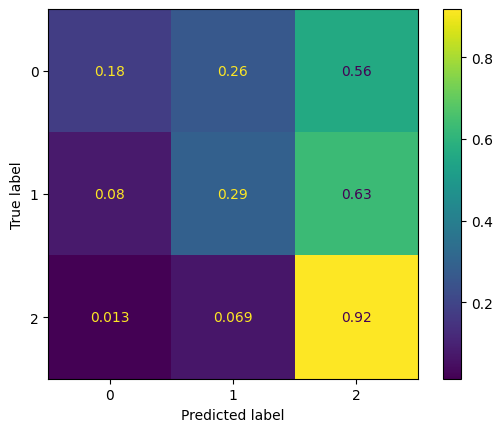

In [247]:
ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=test_y,
        y_pred=np.argmax(pred, axis=1),
        labels=[0, 1, 2],
        normalize="true",
    )
).plot()
plt.show()

In [248]:
log_loss(y_true=test_y, y_pred=pred)

0.8556858181946161

As can be seen, the performance of the model in terms of correctly classifying the within-30 group is still suboptimal. 

In [252]:
print(classification_report_imbalanced(y_true=test_y, y_pred=np.argmax(pred, axis=1)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.36      0.18      0.96      0.24      0.41      0.16      2272
          1       0.60      0.29      0.90      0.39      0.51      0.24      7109
          2       0.64      0.92      0.39      0.75      0.60      0.37     10973

avg / total       0.59      0.62      0.63      0.57      0.55      0.30     20354

